# Prestazioni

Sono state fatte due analisi

- Prestazioni al variare del numero di individui generati.
- Prestazioni al variare del numero di feature che compongono i dati.


In [1]:
import pandas as pd

rf = pd.read_csv("../results/performance/ppga_RandomForestClassifier_pop_final3.csv")
mlp = pd.read_csv("../results/performance/ppga_MLPClassifier_pop_final3.csv")
svm = pd.read_csv("../results/performance/ppga_SVC_pop_final3.csv")

ppga_df = pd.concat([rf, mlp, svm], axis=0)
ppga_df = (
    ppga_df.groupby(by=["classifier", "population_size", "workers"])
    .mean()[["time", "ptime"]]
    .reset_index()
)

ppga_df

,classifier,population_size,workers,time,ptime
0,MLPClassifier,1000,1,3.276289,1.51666
1,MLPClassifier,1000,2,1.388282,0.87000
2,MLPClassifier,1000,4,0.855976,0.45250
3,MLPClassifier,1000,8,0.892651,0.35250
4,MLPClassifier,1000,16,1.119797,0.36500
...,...,...,...,...,...
85,SVC,16000,2,27.793731,22.10000
86,SVC,16000,4,17.904491,11.63250
87,SVC,16000,8,12.419058,6.08500
88,SVC,16000,16,10.229195,3.99500


In [2]:
def compute_speedup(df, field):
    speed_up = []
    for model in df["classifier"].unique():
        for ps in df["population_size"].unique():
            mask1 = (
                (df["classifier"] == model)
                & (df["population_size"] == ps)
                & (df["workers"] == 1)
            )
            a1 = df[mask1][field].to_numpy()
            for w in df["workers"].unique():
                mask = (
                    (df["classifier"] == model)
                    & (df["population_size"] == ps)
                    & (df["workers"] == w)
                )
                a = df[mask][field].to_numpy()
                speed_up.append((a1 / a)[0])
            # print(speed_up[-1])
    if field == "time":
        df["speed_up"] = pd.Series(speed_up)
    else:
        df["p_speed_up"] = pd.Series(speed_up)

    return df


ppga_df = compute_speedup(ppga_df, "time")
ppga_df = compute_speedup(ppga_df, "ptime")
ppga_df

,classifier,population_size,workers,time,ptime,speed_up,p_speed_up
0,MLPClassifier,1000,1,3.276289,1.51666,1.000000,1.000000
1,MLPClassifier,1000,2,1.388282,0.87000,2.359960,1.743287
2,MLPClassifier,1000,4,0.855976,0.45250,3.827547,3.351734
3,MLPClassifier,1000,8,0.892651,0.35250,3.670291,4.302580
4,MLPClassifier,1000,16,1.119797,0.36500,2.925789,4.155232
...,...,...,...,...,...,...,...
85,SVC,16000,2,27.793731,22.10000,3.156276,1.887514
86,SVC,16000,4,17.904491,11.63250,4.899591,3.585992
87,SVC,16000,8,12.419058,6.08500,7.063715,6.855226
88,SVC,16000,16,10.229195,3.99500,8.575913,10.441565


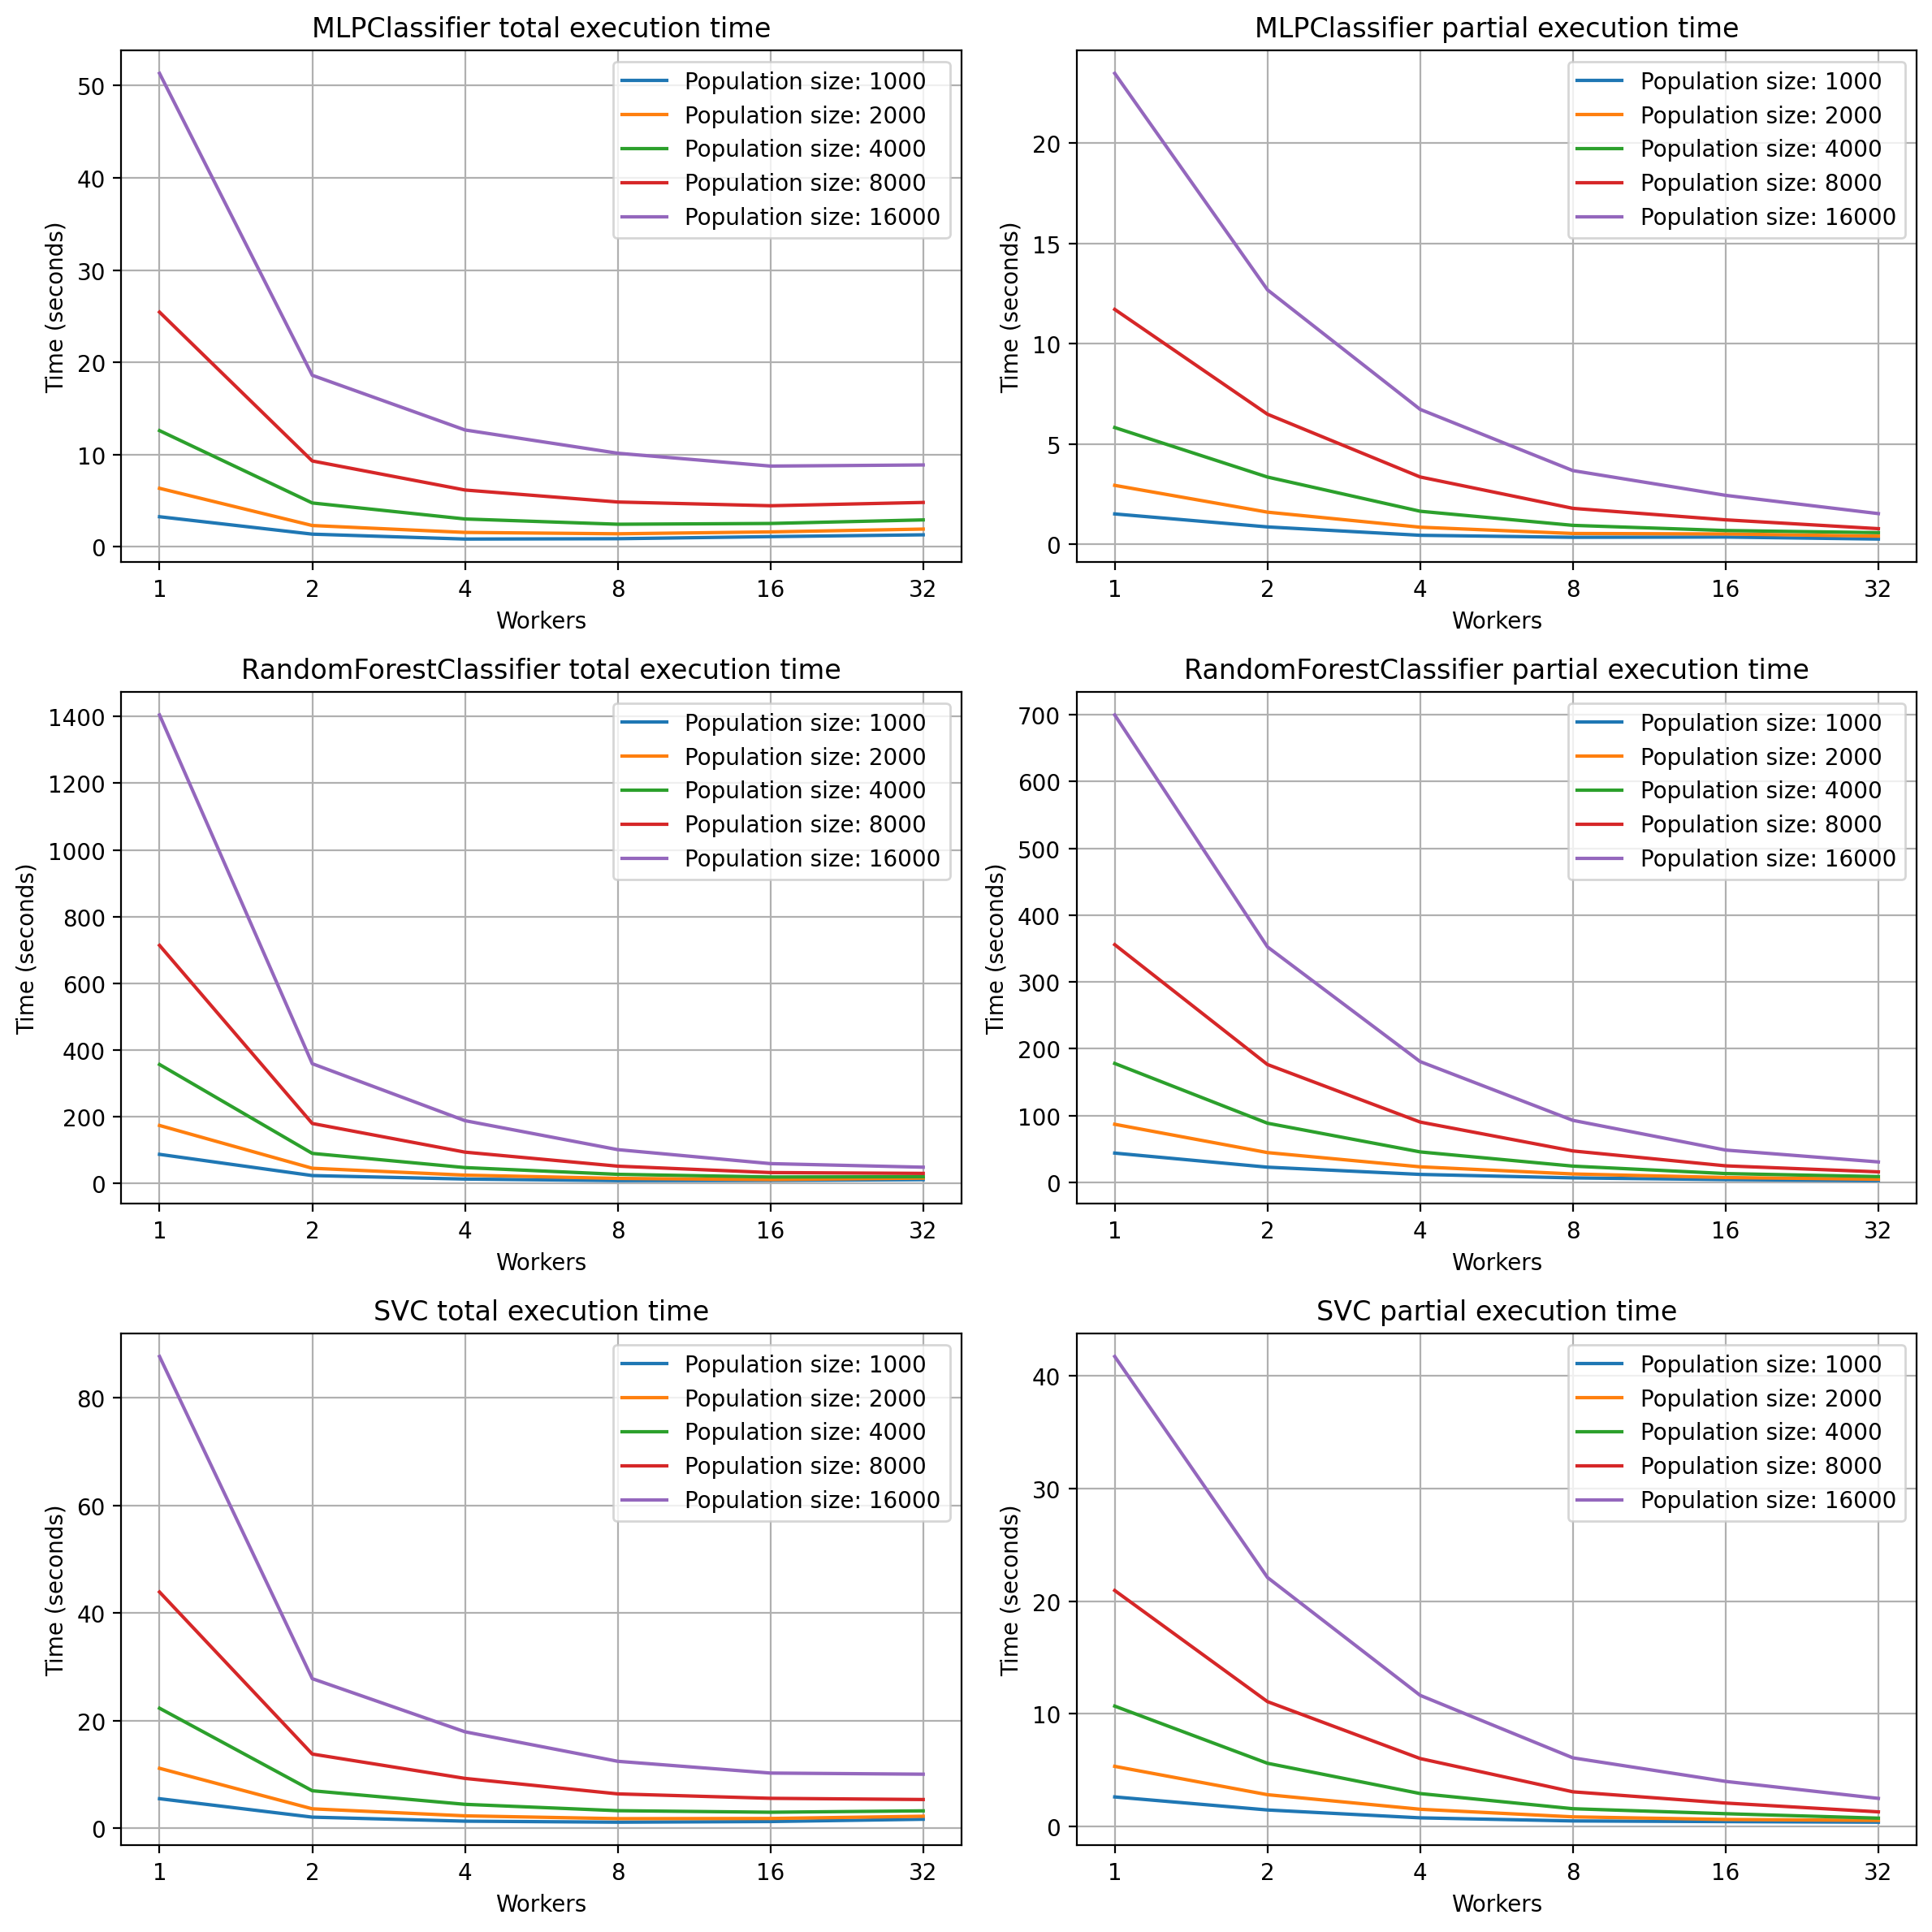

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def plot_time(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(models), 2, figsize=(12, 12), dpi=200)

    for i, model in enumerate(models):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i, 0].set_title(f"{model} total execution time")
            axes[i, 0].set_xlabel("Workers")
            axes[i, 0].set_ylabel("Time (seconds)")
            axes[i, 0].plot(
                workers,
                df[mask]["time"].values,
                label=f"Population size: {ps}",
            )

            axes[i, 0].set_xscale("log", base=2)
            axes[i, 0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 0].grid()
            axes[i, 0].legend()

            axes[i, 1].set_title(f"{model} partial execution time")
            axes[i, 1].set_xlabel("Workers")
            axes[i, 1].set_ylabel("Time (seconds)")
            axes[i, 1].plot(
                workers,
                df[mask]["ptime"].values,
                label=f"Population size: {ps}",
            )

            axes[i, 1].set_xscale("log", base=2)
            axes[i, 1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 1].grid()
            axes[i, 1].legend()

    plt.tight_layout()
    plt.show()


plot_time(ppga_df)

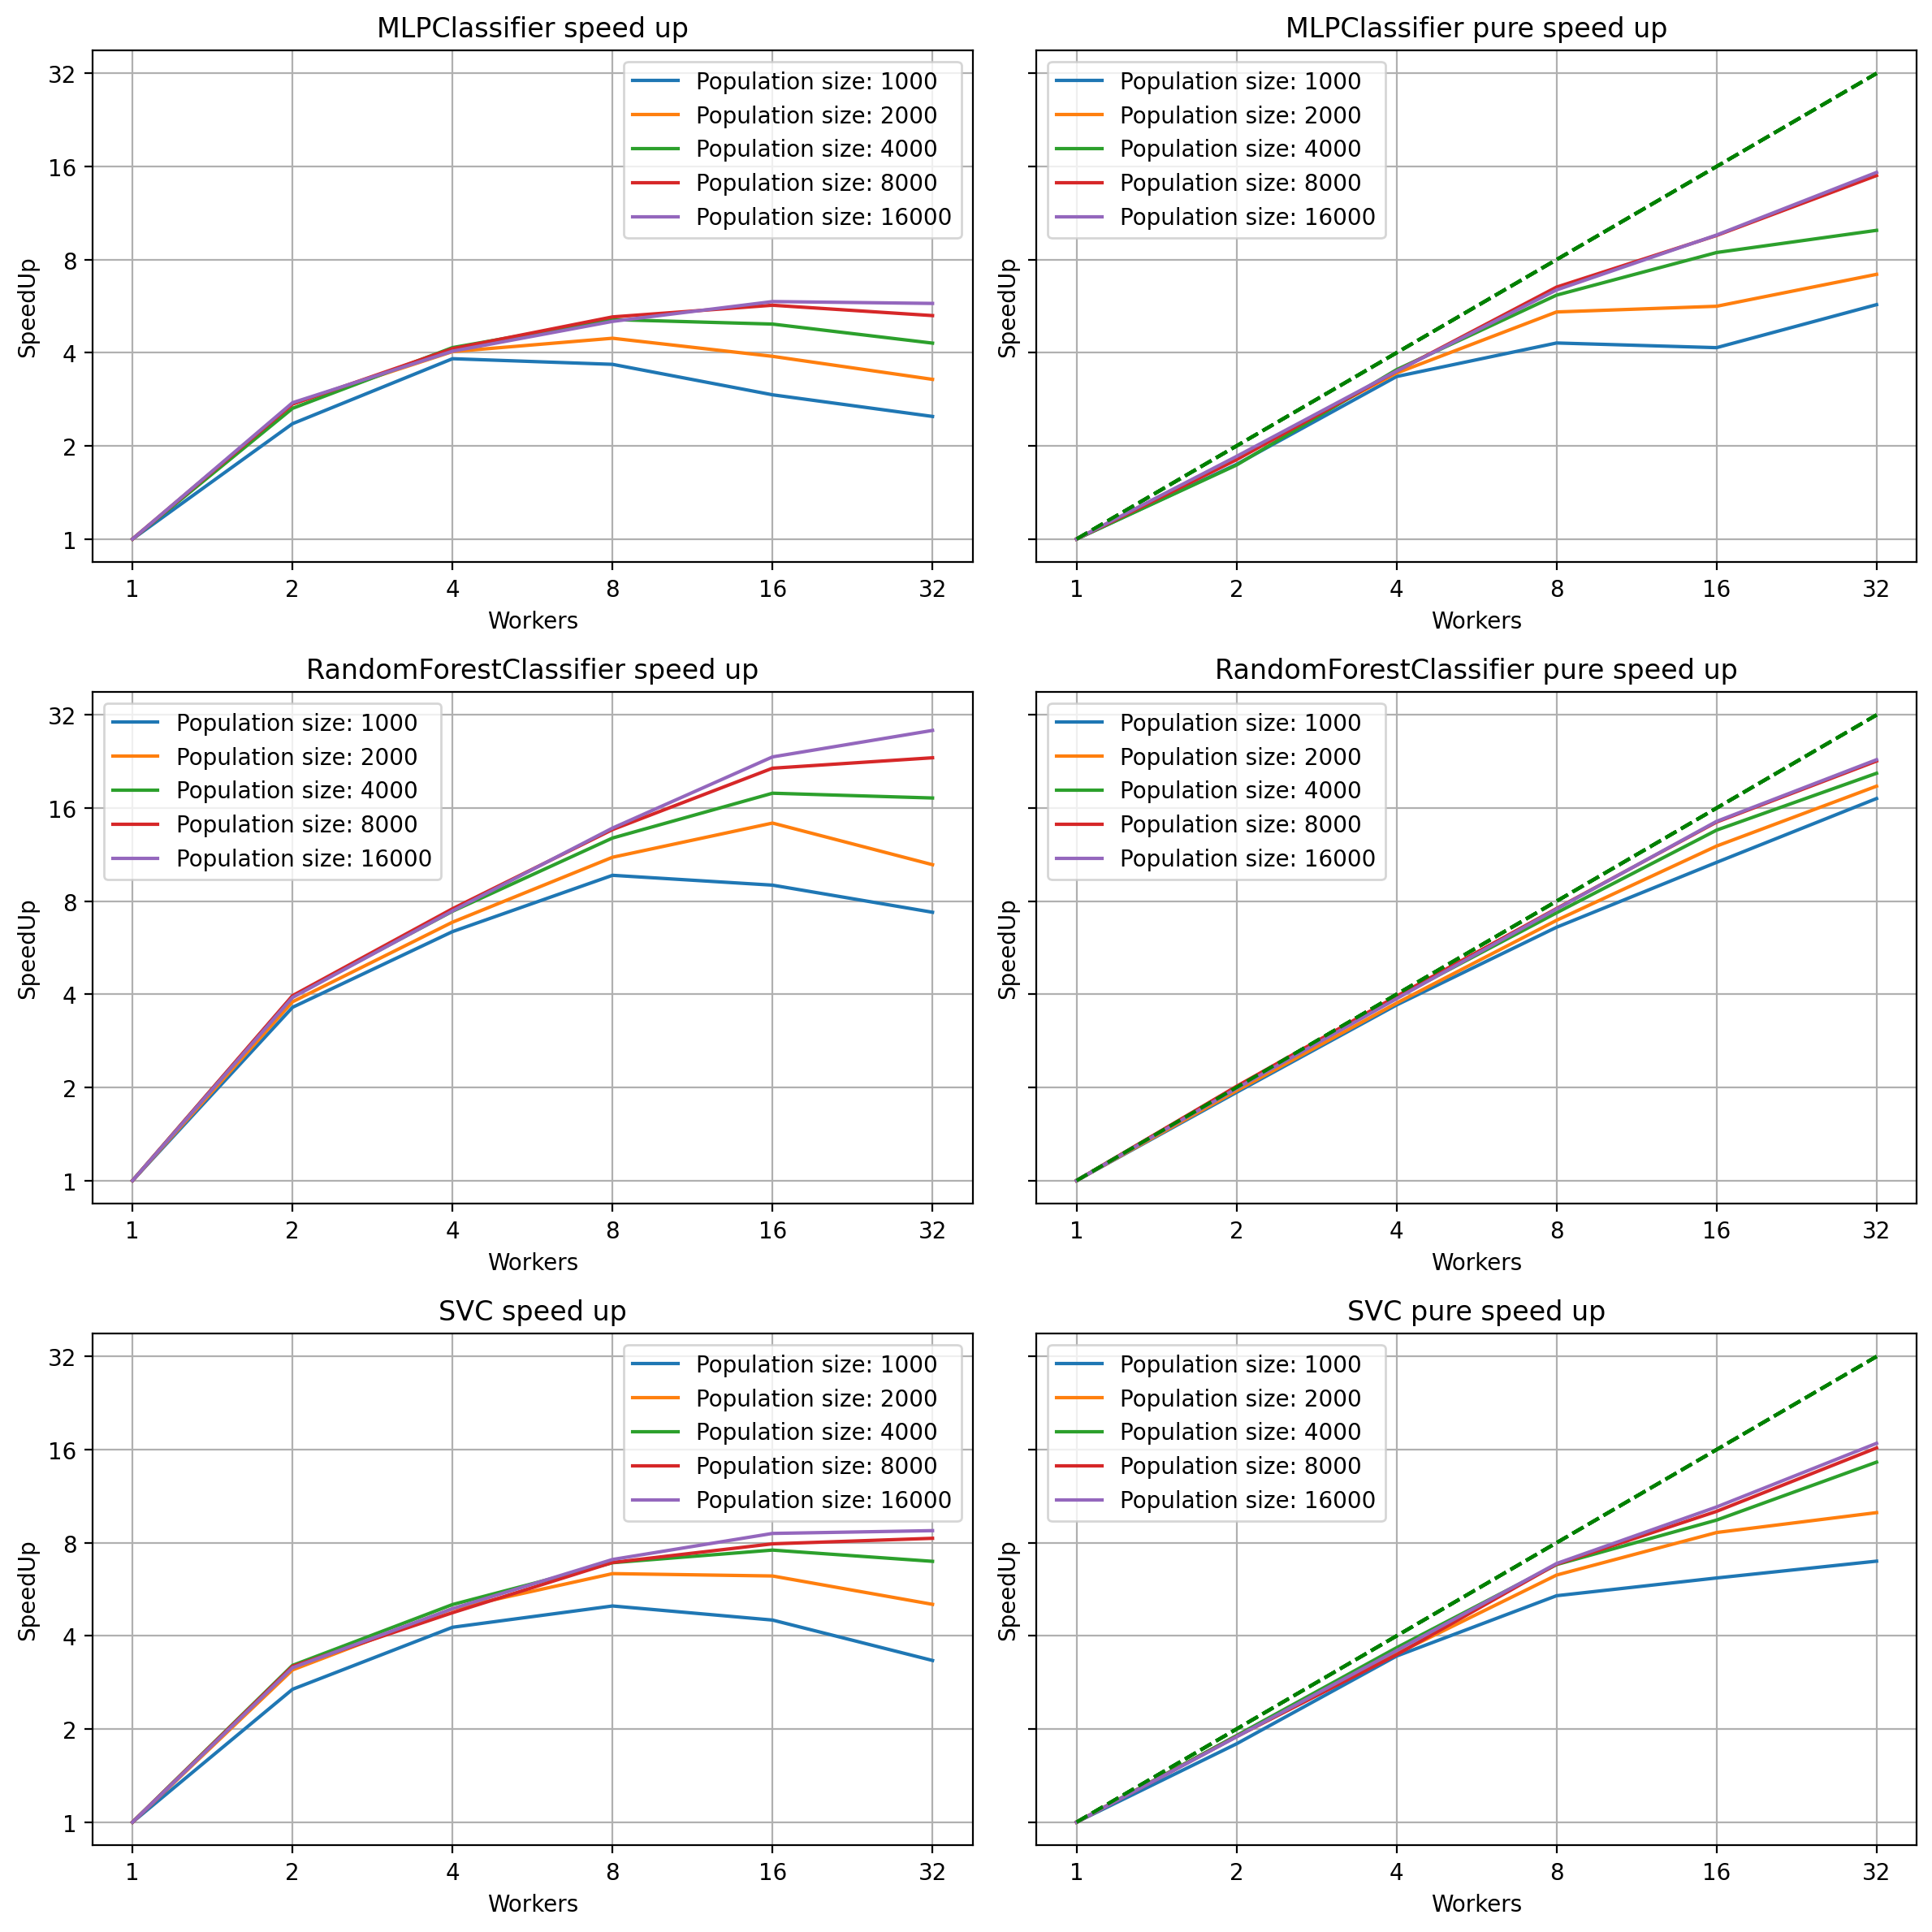

In [5]:
def plot_speedup(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(models), 2, sharey=True, figsize=(12, 12), dpi=200)

    for i, model in enumerate(models):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i, 0].set_title(f"{model} speed up")
            axes[i, 0].set_xlabel("Workers")
            axes[i, 0].set_ylabel("SpeedUp")
            axes[i, 0].plot(
                workers,
                df[mask]["speed_up"].to_numpy(),
                label=f"Population size: {ps}",
            )

            axes[i, 0].set_xscale("log", base=2)
            axes[i, 0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 0].grid()
            axes[i, 0].legend()

            axes[i, 1].set_title(f"{model} pure speed up")
            axes[i, 1].set_xlabel("Workers")
            axes[i, 1].set_ylabel("SpeedUp")
            axes[i, 1].plot(
                workers,
                df[mask]["p_speed_up"],
                label=f"Population size: {ps}",
            )
            axes[i, 1].plot(workers, workers, "g--")

            axes[i, 1].set_xscale("log", base=2)
            axes[i, 1].set_yscale("log", base=2)
            axes[i, 1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 1].set_yticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 1].grid()
            axes[i, 1].legend()

    plt.tight_layout()
    plt.show()


plot_speedup(ppga_df)

In [13]:
mlp = pd.read_csv("../results/performance/deap_MLPClassifier_pop_final3.csv")
svm = pd.read_csv("../results/performance/deap_SVC_pop_final3.csv")
rf = pd.read_csv("../results/performance/deap_RandomForestClassifier_pop_final2.csv")

deap_df = pd.concat([mlp, svm, rf], axis=0)
deap_df = (
    deap_df.groupby(by=["classifier", "population_size", "workers"])
    .mean()[["time", "ptime"]]
    .sort_values(by=["classifier", "population_size", "workers"])
    .reset_index()
)

deap_df

,classifier,population_size,workers,time,ptime
0,MLPClassifier,1000,1,5.838197,1.650671
1,MLPClassifier,1000,2,4.735578,1.002500
2,MLPClassifier,1000,4,4.719870,0.797500
3,MLPClassifier,1000,8,4.830379,0.522500
4,MLPClassifier,1000,16,4.996124,0.405000
...,...,...,...,...,...
85,SVC,16000,2,313.098080,25.677500
86,SVC,16000,4,298.354721,13.822500
87,SVC,16000,8,291.640669,7.605000
88,SVC,16000,16,290.412387,4.720000


In [14]:
deap_df = compute_speedup(deap_df, "time")
deap_df = compute_speedup(deap_df, "ptime")
deap_df

,classifier,population_size,workers,time,ptime,speed_up,p_speed_up
0,MLPClassifier,1000,1,5.838197,1.650671,1.000000,1.000000
1,MLPClassifier,1000,2,4.735578,1.002500,1.232837,1.646555
2,MLPClassifier,1000,4,4.719870,0.797500,1.236940,2.069807
3,MLPClassifier,1000,8,4.830379,0.522500,1.208642,3.159179
4,MLPClassifier,1000,16,4.996124,0.405000,1.168545,4.075731
...,...,...,...,...,...,...,...
85,SVC,16000,2,313.098080,25.677500,1.139958,1.858804
86,SVC,16000,4,298.354721,13.822500,1.196290,3.453026
87,SVC,16000,8,291.640669,7.605000,1.223831,6.276061
88,SVC,16000,16,290.412387,4.720000,1.229007,10.112171


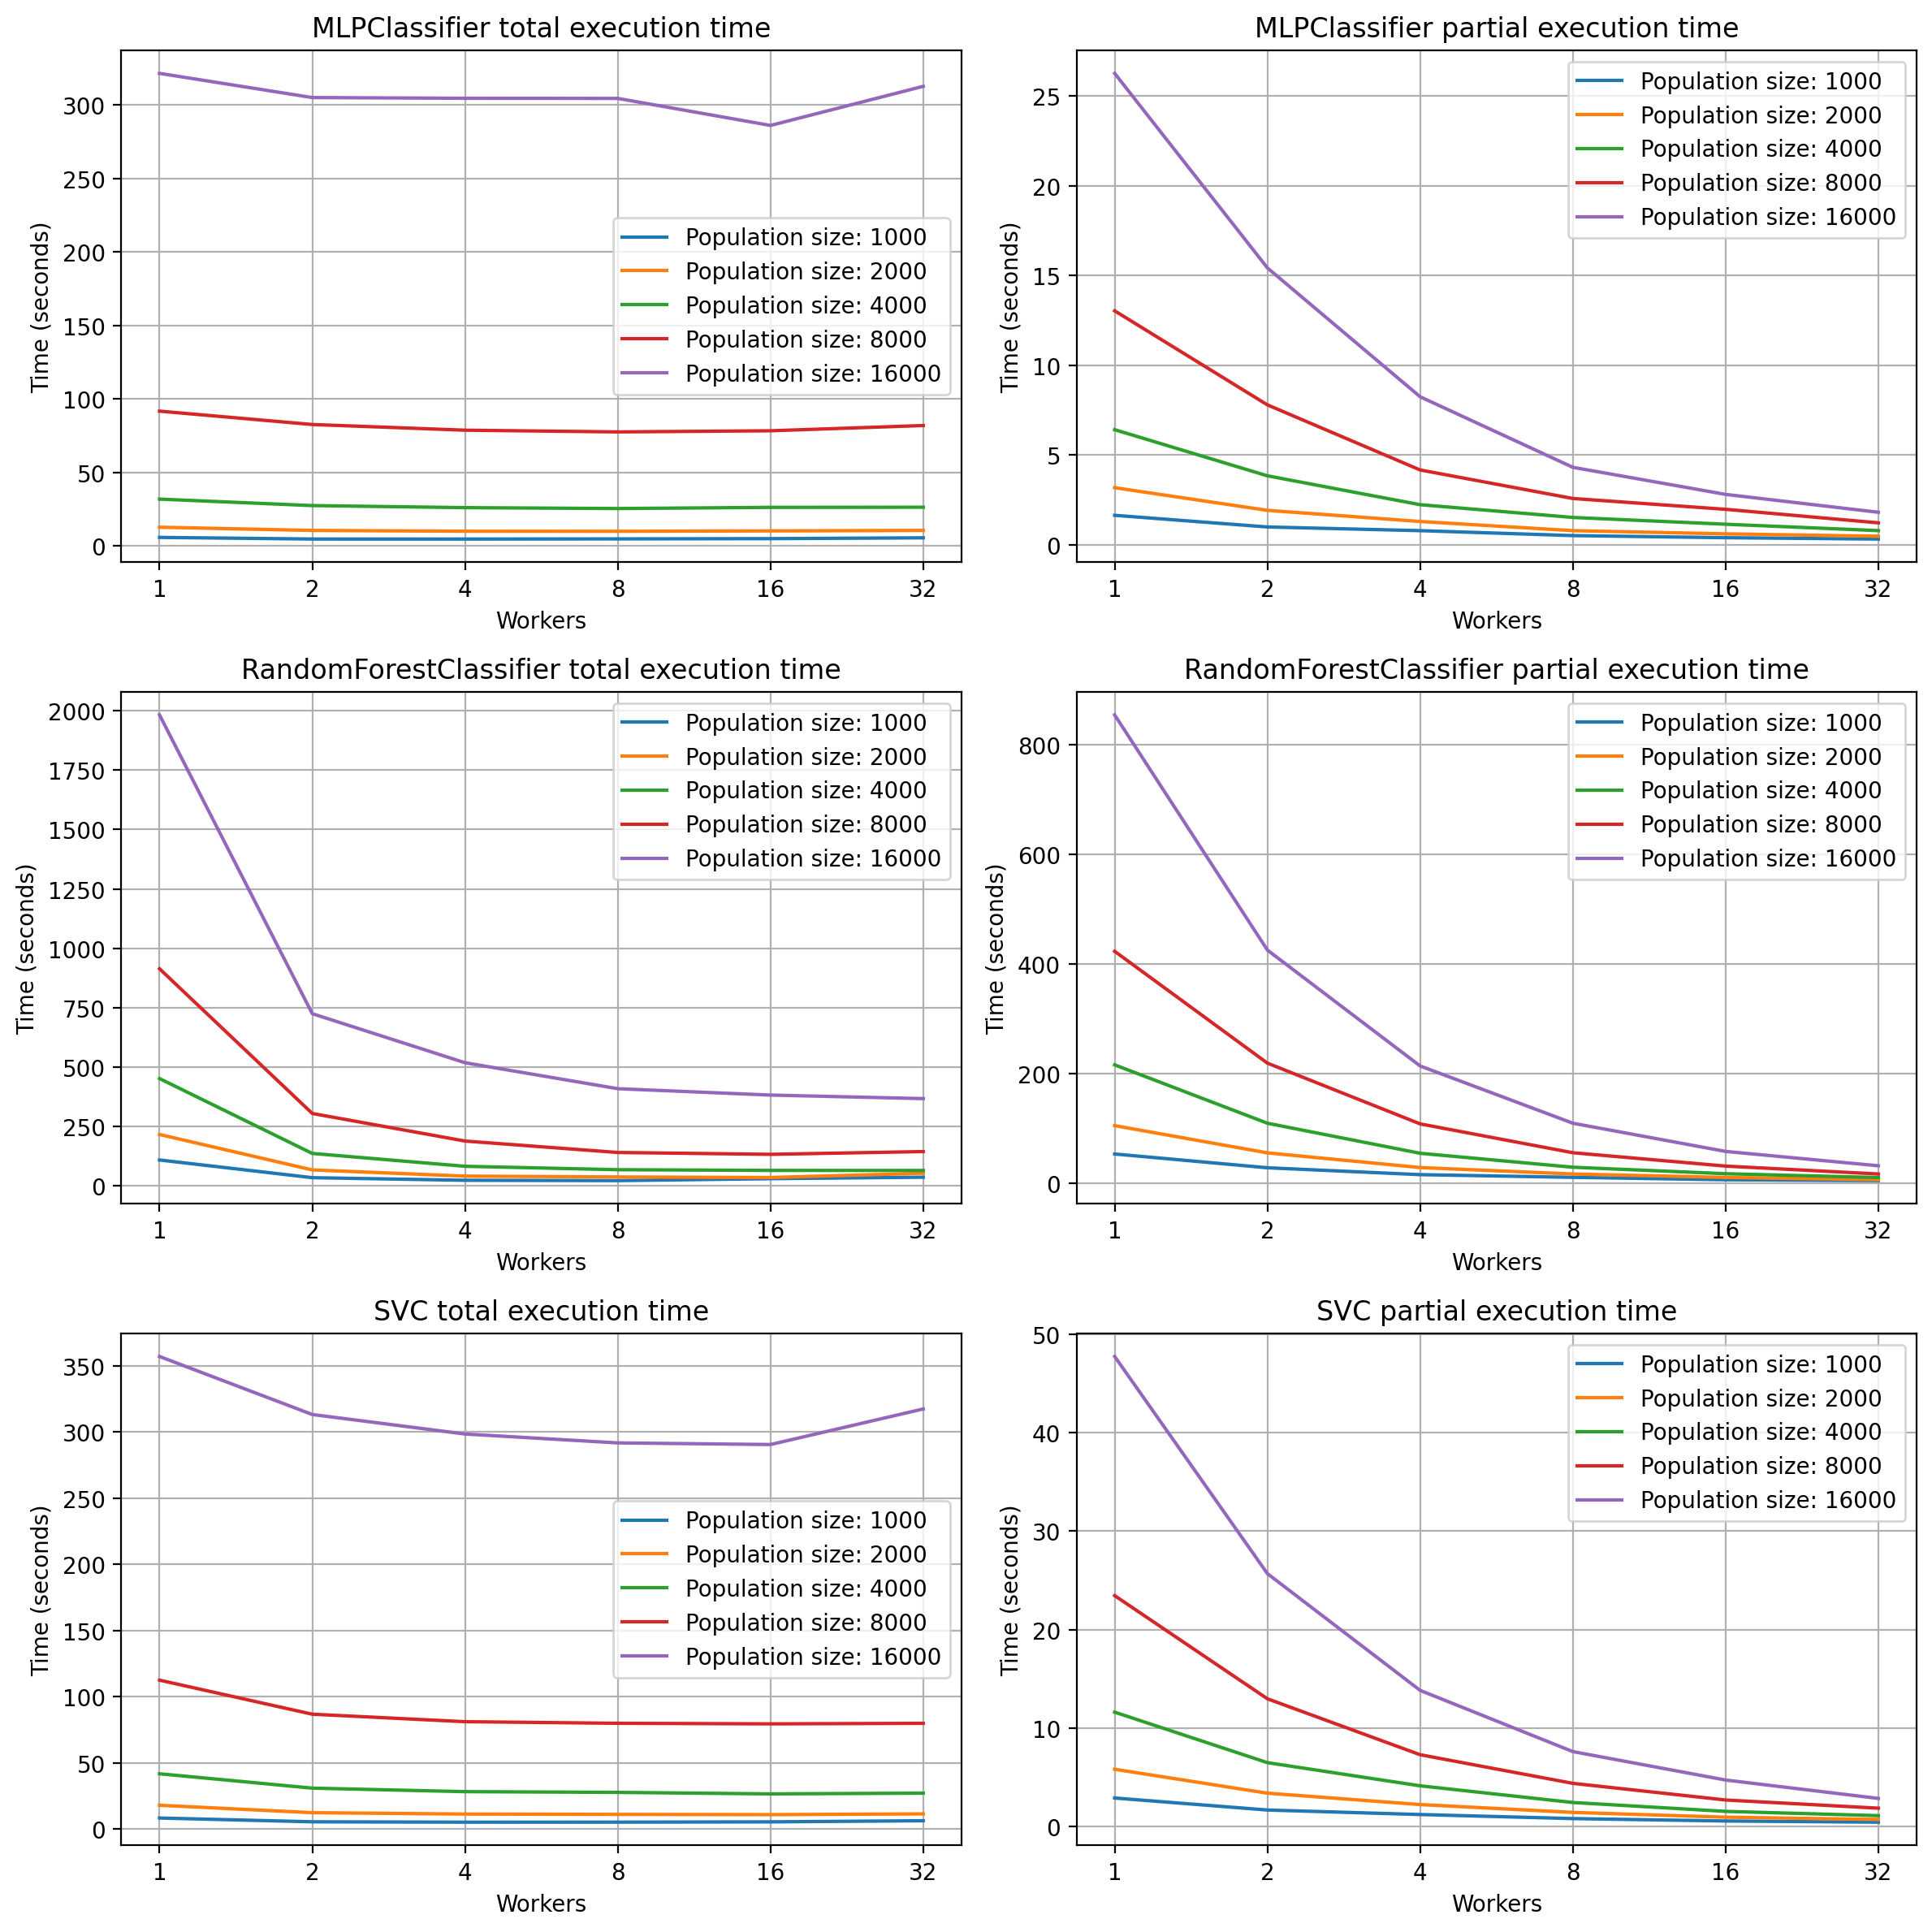

In [15]:
plot_time(deap_df)

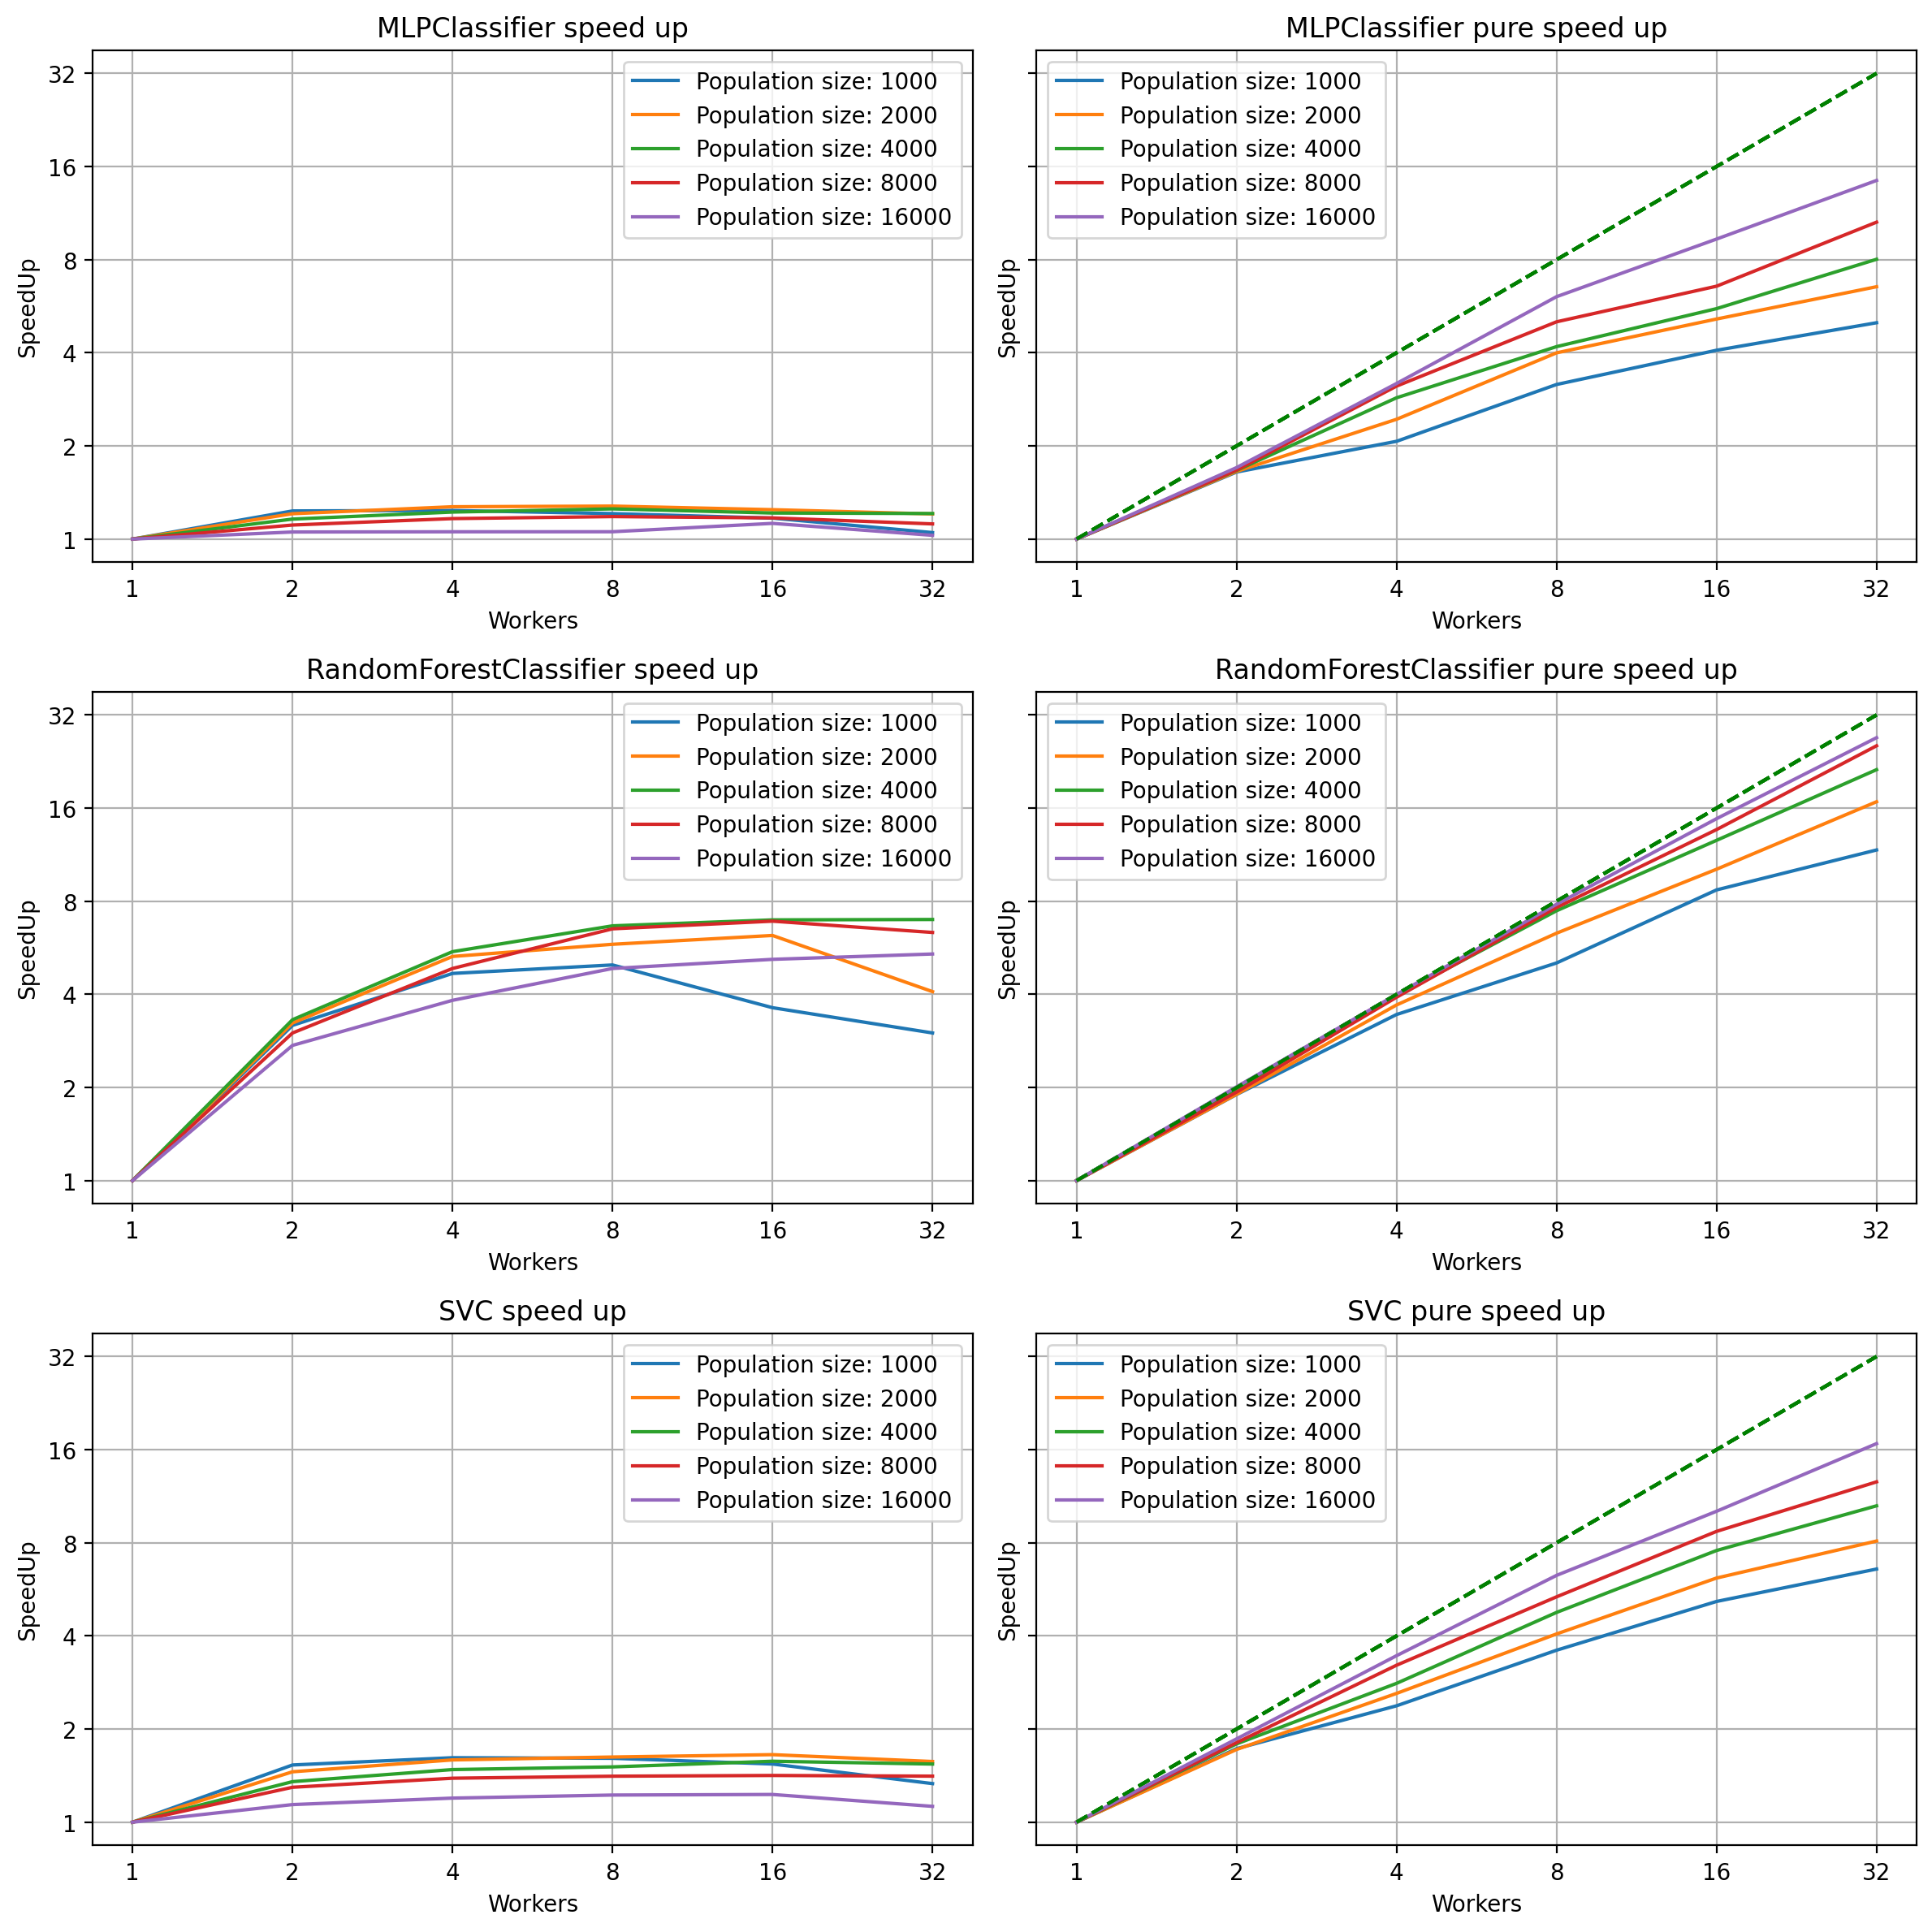

In [16]:
plot_speedup(deap_df)